Colab Version - https://colab.research.google.com/drive/1Lmz5rLEWiB22_PE_a9D2cDr8pmPFY2n8?usp=sharing

<img align="center" src="http://sydney.edu.au/images/content/about/logo-mono.jpg">
<h1 align="center" style="margin-top:10px">Statistical Learning and Data Mining</h1>
<h2 align="center" style="margin-top:20px">Week 9: Decision Trees and Random Forests</h2>
<br>
 
This tutorial shows you how to apply decision trees and random forests to classification problems.
 
<a href="#1.-Work-Analytics-Data">Work analytics data</a> <br>
<a href="#2.-Exploratory-Data-Analysis">Exploratory data analysis</a> <br>
<a href="#3.-Feature-Engineering">Feature engineering</a> <br>
<a href="#4.-Classification-Tree">Classification tree</a> <br>
<a href="#5.-Bagging">Bagging</a> <br>
<a href="#6.-Random-forest">Random forest</a> <br>
<a href="#7.-Interpretation">Interpretation</a> <br>
<a href="#8.-Probability-calibration">Probability calibration</a> <br>
<a href="#9.-Model-selection">Model selection</a> <br>

This notebook relies on the following libraries and settings.

In [1]:
# Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Plot settings
sns.set_context('notebook') # optimises figures for notebook display
sns.set_style('ticks') # set default plot style
colours = ['#4E79A7','#F28E2C','#E15759','#76B7B2','#59A14F', 
           '#EDC949','#AF7AA1','#FF9DA7','#9C755F','#BAB0AB']
sns.set_palette(colours) # set custom color scheme
%matplotlib inline
plt.rcParams['figure.figsize'] = (9, 6)

In [3]:
# Methods
from sklearn.linear_model import LogisticRegressionCV

# Model selection and evaluation tools
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.metrics import precision_score, average_precision_score, log_loss

# 1. HR Analytics Data

We use the [Human Resources Analytics](https://www.kaggle.com/ludobenistant/hr-analytics) dataset available from [Kaggle Datasets](https://www.kaggle.com/datasets).

Our objective is predict which employees will leave the company with highest possible accuracy (zero-one loss).

In [4]:
data = pd.read_csv('HR.csv')
data = data.rename(columns = {'sales': 'role'})
data.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,role,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


As usual, we split the data into training and validation sets.

In [5]:
response = 'left' # whether the employee left the company
predictors = list(data.columns.values)
predictors.remove(response)

index_train, index_valid = train_test_split(np.array(data.index), stratify=data[response], 
                                            train_size=0.7, random_state=5)

train = data.loc[index_train,:].copy()
valid = data.loc[index_valid,:].copy()

y_train = train[response]
y_valid = valid[response]

We have over 10,000 training observations. 

In [6]:
len(train)

10499

# 2. Some EDA


## 2.1 Descriptive statistics

About 24% of employees left the company.

In [7]:
train.describe().round(2)

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,10499.00,10499.00,10499.00,10499.00,10499.00,10499.00,10499.00,10499.00
mean,0.62,0.72,3.79,200.92,3.51,0.14,0.24,0.02
std,0.25,0.17,1.22,49.74,1.48,0.35,0.43,0.15
min,0.09,0.36,2.00,96.00,2.00,0.00,0.00,0.00
25%,0.44,0.56,3.00,156.00,3.00,0.00,0.00,0.00
50%,0.65,0.72,4.00,200.00,3.00,0.00,0.00,0.00
75%,0.82,0.87,5.00,245.00,4.00,0.00,0.00,0.00
max,1.00,1.00,7.00,310.00,10.00,1.00,1.00,1.00


## 2.2 Numerical predictors

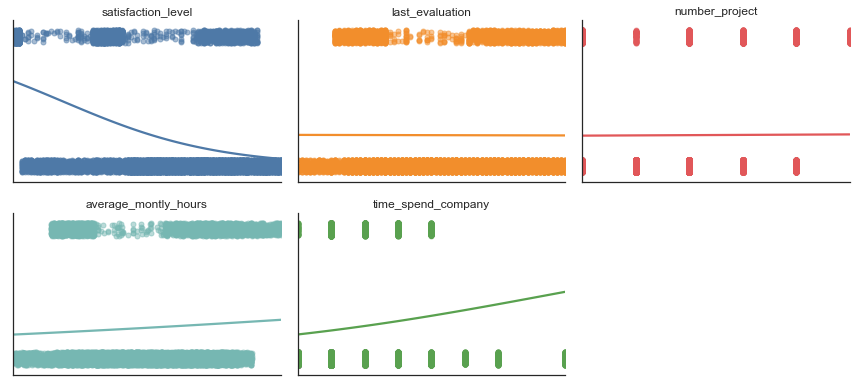

In [8]:
from tutorial9 import plot_logistic_regressions

plot_logistic_regressions(train[predictors].iloc[:,:5], y_train)
plt.show()

## 2.3 Nominal predictors

In [9]:
train.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,role,salary
708,0.11,0.87,6,255,4,0,1,0,sales,low
8749,0.15,0.84,3,201,6,0,0,0,support,medium
7339,0.51,0.59,4,187,3,0,0,0,sales,low
10588,0.81,0.64,4,213,3,0,0,0,support,medium
6442,0.36,0.89,3,197,6,0,0,0,hr,medium


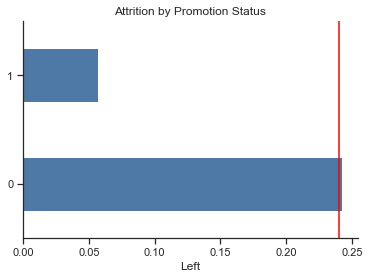

In [10]:
table = (train.groupby('promotion_last_5years')['left'].mean()).sort_values(ascending=False).round(3)

fig, ax = plt.subplots(figsize=(6, 4))
table.plot(kind='barh', ax=ax)

ax.set_ylabel('')
ax.set_xlabel('Left')
ax.set_title('Attrition by Promotion Status')

plt.plot([0.24, 0.24], [-1, 2], color='red')

sns.despine()
plt.show()

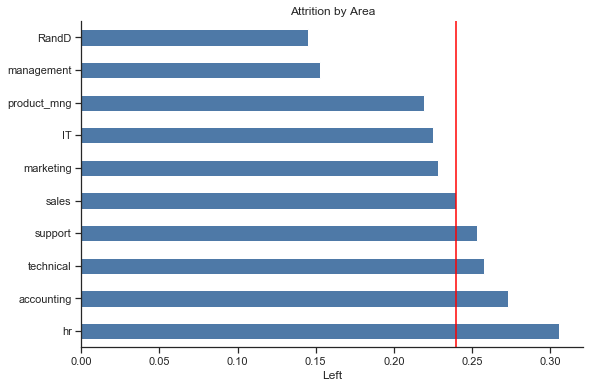

In [11]:
table = (train.groupby('role')['left'].mean()).sort_values(ascending=False).round(3)

fig, ax = plt.subplots()
table.plot(kind='barh', ax=ax)

ax.set_ylabel('')
ax.set_xlabel('Left')
ax.set_title('Attrition by Area')

plt.plot([0.24, 0.24], [-1, 10], color='red')

# plt.legend()
sns.despine()
plt.show()

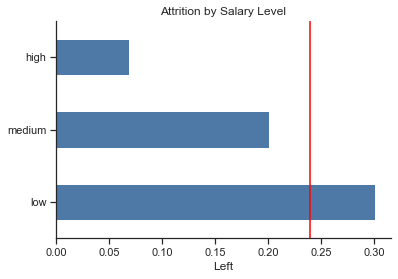

In [12]:
table = (train.groupby('salary')['left'].mean()).sort_values(ascending=False).round(3)

fig, ax = plt.subplots(figsize=(6, 4))
table.plot(kind='barh', ax=ax)

ax.set_ylabel('')
ax.set_xlabel('Left')
ax.set_title('Attrition by Salary Level')

plt.plot([0.24, 0.24], [-1, 3], color='red')

sns.despine()
plt.show()

# 3. Feature Engineering

Feature engineering only is a matter of encoding the categorical variables. We use one-hot encoding, but it may also be a good idea to experiment with variations of target encoding for the random forest. 

In [13]:
train.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,role,salary
708,0.11,0.87,6,255,4,0,1,0,sales,low
8749,0.15,0.84,3,201,6,0,0,0,support,medium
7339,0.51,0.59,4,187,3,0,0,0,sales,low
10588,0.81,0.64,4,213,3,0,0,0,support,medium
6442,0.36,0.89,3,197,6,0,0,0,hr,medium


In [14]:
def feat_engineering(df, index_train, index_test):
    
    data = df.copy()
    
    dummies = pd.get_dummies(data['role'])
    data = data.join(dummies)
    data = data.drop('role', axis= 1)

    dummies = pd.get_dummies(data['salary'], prefix='salary')
    data = data.join(dummies)
    data = data.drop('salary', axis= 1)
    
    features = list(data.columns.values)
    features.remove(response)
    
    X_train = data.loc[index_train, features].copy()
    X_valid =  data.loc[index_valid, features].copy()
    
    return X_train, X_valid, features

X_train, X_valid, feature_names = feat_engineering(data, index_train, index_valid)

In [15]:
X_train.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,IT,RandD,accounting,hr,management,marketing,product_mng,sales,support,technical,salary_high,salary_low,salary_medium
708,0.11,0.87,6,255,4,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
8749,0.15,0.84,3,201,6,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
7339,0.51,0.59,4,187,3,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
10588,0.81,0.64,4,213,3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
6442,0.36,0.89,3,197,6,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1


In [16]:
len(X_train)

10499

# 4. Classification Tree

## 4.1 Growing and visualising a classification tree

The basic syntax for fitting a classification tree is as follows. We start with a small tree with tree leaves for visualisation.

In [19]:
from sklearn.tree import DecisionTreeClassifier

""" Different Possible tuning parameters

    min_samples_leaf : int
        The minimum number of samples required to be at a leaf node
    max_depth : int
        The maximum depth of the tree. 
    min_samples_split : int
         The minimum number of samples required to split an internal node
    max_leaf_nodes : int
        Grow a tree with max_leaf_nodes in best-first fashion
"""

clf = DecisionTreeClassifier(criterion='entropy', max_leaf_nodes=2, min_samples_leaf=1)
# clf = DecisionTreeClassifier(criterion='entropy', min_samples_leaf=1000)
clf.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_leaf_nodes=2)

You can visualise the decision tree using Graphviz as follows.

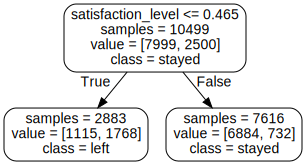

In [20]:
import graphviz
from sklearn.tree import export_graphviz

dot_data = export_graphviz(clf, out_file=None , impurity=False, feature_names = feature_names, 
                           class_names=['stayed', 'left'], rounded=True) 
graph = graphviz.Source(dot_data)
graph

Here's an alternative if you can't get Graphviz to work.

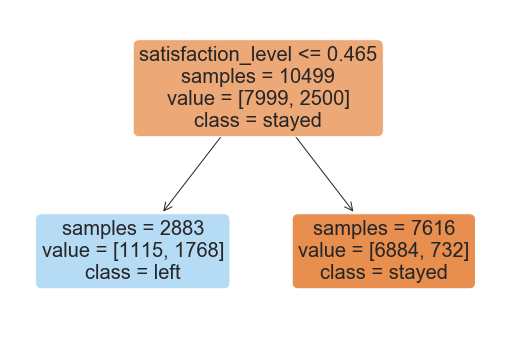

In [83]:
from sklearn.tree import plot_tree

plot_tree(clf, feature_names = feature_names, class_names=['stayed','left'], impurity=False,
          rounded=True, filled = True)
plt.show()

The [dtreeviz](https://github.com/parrt/dtreeviz) provides more elaborate decision tree visualisations.

In [17]:
from dtreeviz.trees import *

viz = dtreeviz(clf, X_train, y_train, target_name='Employee status', feature_names=feature_names,
               class_names=['Stayed', 'Left'], scale=2)  
              
viz

ModuleNotFoundError: No module named 'dtreeviz'

Increasing the number of leaves to three allows to visualise how recursive binary splitting grows the tree in a greedy fashion. The top node remains the same as we add a new decision node on the right-hand side.

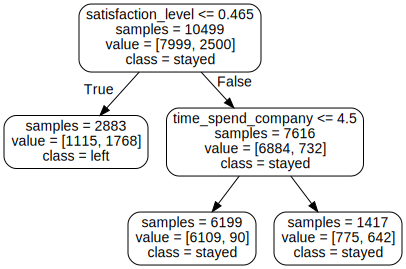

In [84]:
clf = DecisionTreeClassifier(criterion='entropy', max_leaf_nodes=3)
clf.fit(X_train, y_train)

dot_data = export_graphviz(clf, out_file=None , impurity=False, feature_names = feature_names, 
                           class_names=['stayed','left'], rounded=True) 
graph = graphviz.Source(dot_data)
graph

And here's the the dtreeviz visualisation again:

In [19]:
viz = dtreeviz(clf, X_train, y_train, target_name='Employee status', feature_names = feature_names,
               class_names=['Stayed', 'Left'], scale= 2)  
              
viz

NameError: name 'dtreeviz' is not defined

## 4.2 Cost-complexity pruning

To build a classification tree for prediction, we first grow a large tree by recursive binary splitting and then use cost-complexity criterion to prune it to an optimal size.

To implement this procedure, we first have to run the the following code obtain the relevant grid of values for tree size penalty $\alpha$. Each $\alpha$ corresponds to a smaller version of the large tree.

In [85]:
model = DecisionTreeClassifier(criterion='entropy', min_samples_leaf=5)

path = model.cost_complexity_pruning_path(X_train, y_train)
alphas = path.ccp_alphas

In [88]:
[round(x, 6) for x in alphas]

[0.0,
 0.0,
 0.0,
 0.0,
 3.3e-05,
 8.8e-05,
 0.000103,
 0.000117,
 0.000117,
 0.000129,
 0.000129,
 0.000139,
 0.000141,
 0.000141,
 0.000151,
 0.000157,
 0.000168,
 0.000177,
 0.000179,
 0.000184,
 0.000192,
 0.000192,
 0.000193,
 0.000193,
 0.000195,
 0.000196,
 0.0002,
 0.000202,
 0.000202,
 0.000206,
 0.000211,
 0.000218,
 0.000218,
 0.000223,
 0.000223,
 0.000225,
 0.000233,
 0.000235,
 0.000238,
 0.000239,
 0.000249,
 0.000253,
 0.000253,
 0.000263,
 0.000264,
 0.000265,
 0.00027,
 0.000271,
 0.000271,
 0.000272,
 0.000281,
 0.000284,
 0.000288,
 0.000288,
 0.000294,
 0.000294,
 0.000304,
 0.000307,
 0.000311,
 0.000312,
 0.000322,
 0.000326,
 0.000332,
 0.000333,
 0.000334,
 0.000337,
 0.000343,
 0.000346,
 0.000353,
 0.000353,
 0.000354,
 0.00036,
 0.000368,
 0.00037,
 0.000382,
 0.000385,
 0.00039,
 0.000393,
 0.000396,
 0.000404,
 0.00041,
 0.000411,
 0.000435,
 0.000435,
 0.000446,
 0.000447,
 0.000461,
 0.000474,
 0.0005,
 0.000504,
 0.000514,
 0.000519,
 0.000523,
 0.00052

We then run a grid search to find the best $\alpha$.

In [89]:
model = DecisionTreeClassifier(criterion='entropy', min_samples_leaf=5)

search_space = {'ccp_alpha': alphas}

tree_search = GridSearchCV(model, search_space, cv=5 , scoring='neg_log_loss')
tree_search.fit(X_train, y_train)
tree = tree_search.best_estimator_

print('Best parameters found by grid search:', tree_search.best_params_, '\n')

Best parameters found by grid search: {'ccp_alpha': 0.0016680985845902233} 



Here's the final tree:

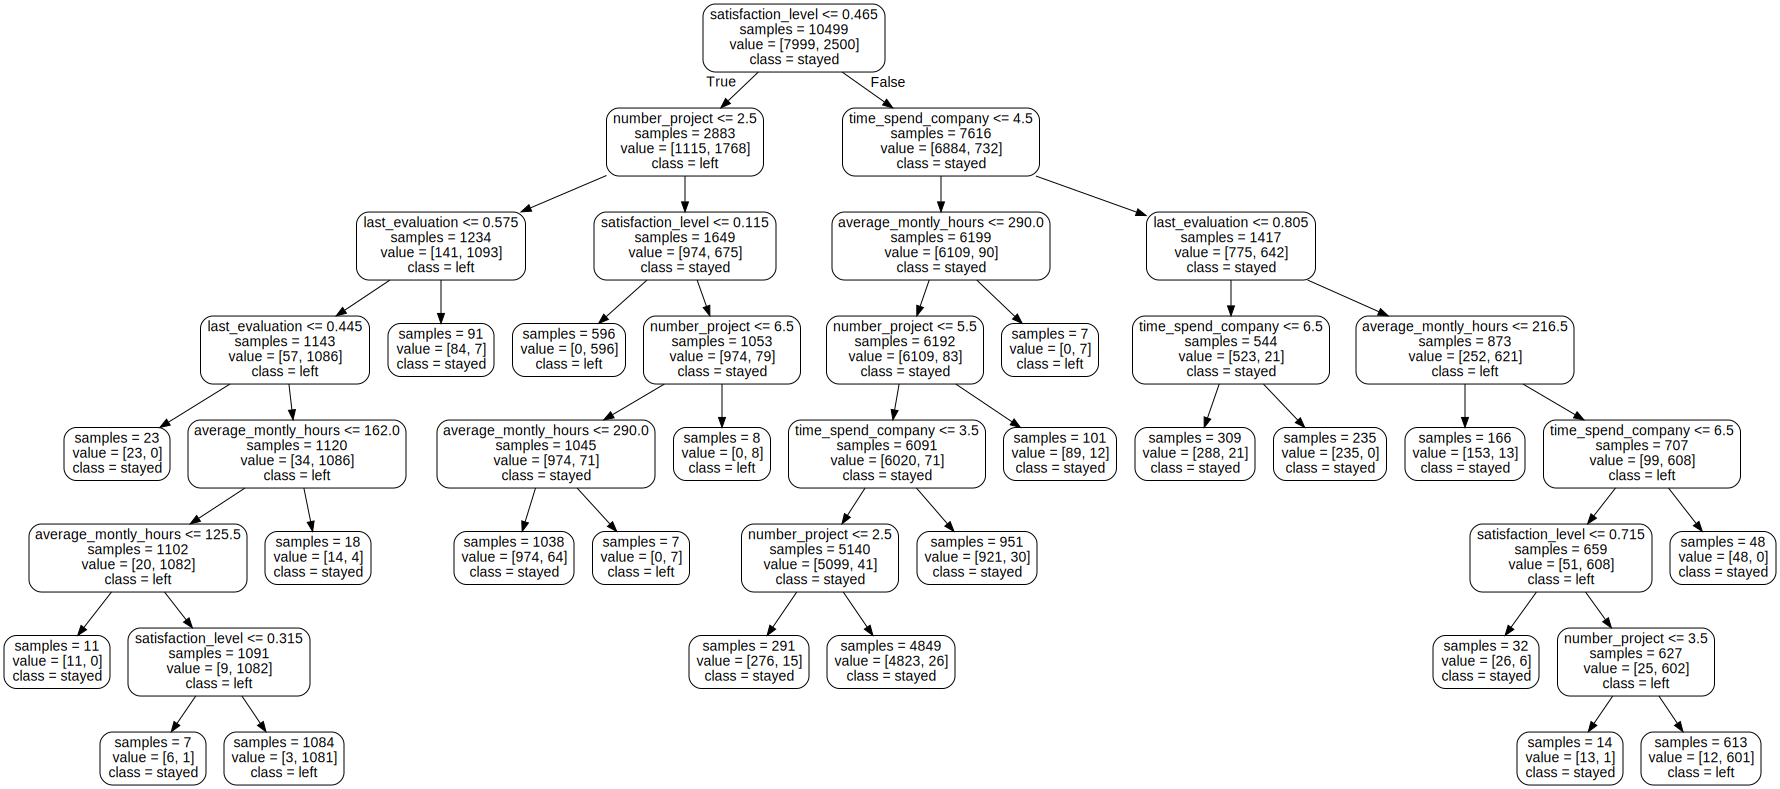

In [48]:
dot_data = export_graphviz(tree, out_file=None , impurity=False, feature_names = feature_names,
                           class_names=['stayed','left'], rounded=True) 
graph = graphviz.Source(dot_data)
graph.render('tree02') # saves tree to a file
graph

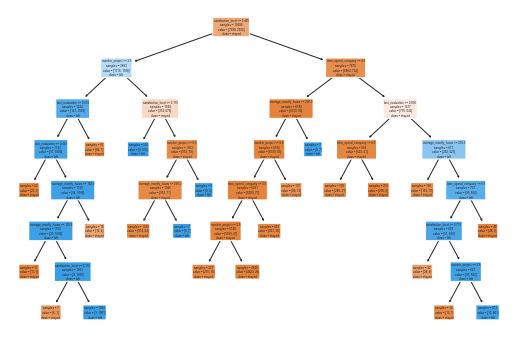

In [90]:
from sklearn.tree import plot_tree

plot_tree(tree, feature_names = feature_names, class_names=['stayed','left'], impurity=False,
          rounded=True, filled = True)
plt.show()

# 5. Bagging

Bagging predicts the response by averaging across a large number of trees fitted on different versions of the training set. You can use this method as follows.

In [91]:
from sklearn.ensemble import BaggingClassifier

bag = BaggingClassifier(DecisionTreeClassifier(criterion='entropy'), n_estimators=1000, random_state=42)
bag.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy'),
                  n_estimators=1000, random_state=42)

# 6. Random forest

## 6.1 Fitting a random forest

The basic code to train a random forest is as follows.

In [44]:
X_train.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,IT,RandD,accounting,hr,management,marketing,product_mng,sales,support,technical,salary_high,salary_low,salary_medium
708,0.11,0.87,6,255,4,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
8749,0.15,0.84,3,201,6,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
7339,0.51,0.59,4,187,3,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
10588,0.81,0.64,4,213,3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
6442,0.36,0.89,3,197,6,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1


In [45]:
X_train.shape

(10499, 20)

In [94]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, criterion='entropy', max_features=3, min_samples_leaf=5)
rf.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_features=3, min_samples_leaf=5)

## 6.2 Hyperparameter optimisation 

We again use optuna for hyperparameter optimisation. The following use the accuracy as the metric for computing the cross-validation error, but the cross-entropy may be more appropriate in other settings where we care more about the quality of the probability estimates. 

In [26]:
import optuna
from optuna.samplers import TPESampler
from sklearn.model_selection import cross_val_score

def objective(trial):
    criterion = trial.suggest_categorical('criterion', ['entropy', 'gini'])
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    max_features = trial.suggest_int('max_features', 1, 20)
    
    
    model = RandomForestClassifier(n_estimators=100,
                                   criterion=criterion,  
                                   max_features=max_features, 
                                   min_samples_leaf=min_samples_leaf,
                                   random_state=1)
    
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    loss = 1 - np.mean(scores)
    
    return loss

sampler = TPESampler(seed=42) 
study = optuna.create_study(direction='minimize', sampler=sampler)
study.optimize(objective, n_trials=100, timeout=120) 

# the timeout should be as high as possible in a real application

[I 2021-10-10 10:53:36,259] A new study created in memory with name: no-name-a4b4bbe3-6513-48ab-8cf7-7f7e1d008025
[I 2021-10-10 10:53:40,336] Trial 0 finished with value: 0.026192835590644115 and parameters: {'criterion': 'gini', 'min_samples_leaf': 15, 'max_features': 12}. Best is trial 0 with value: 0.026192835590644115.
[I 2021-10-10 10:53:45,909] Trial 1 finished with value: 0.014953560652464781 and parameters: {'criterion': 'entropy', 'min_samples_leaf': 2, 'max_features': 18}. Best is trial 1 with value: 0.014953560652464781.
[I 2021-10-10 10:53:52,309] Trial 2 finished with value: 0.01304857188230224 and parameters: {'criterion': 'gini', 'min_samples_leaf': 1, 'max_features': 20}. Best is trial 2 with value: 0.01304857188230224.
[I 2021-10-10 10:53:54,489] Trial 3 finished with value: 0.023049842328546455 and parameters: {'criterion': 'entropy', 'min_samples_leaf': 4, 'max_features': 4}. Best is trial 2 with value: 0.01304857188230224.
[I 2021-10-10 10:53:56,946] Trial 4 finishe

Here are the best hyperparameters:

In [27]:
params = study.best_params
params

{'criterion': 'gini', 'min_samples_leaf': 1, 'max_features': 14}

In [44]:
params = {'criterion': 'gini', 'min_samples_leaf': 1, 'max_features': 14}

You should use as many trees as possible when re-fitting the model. We use a thousand here just so that the rest of the code doesn't take too long to run.

In [45]:
# **params "unpacks" the dictionary and passes the items as inputs to the random forest clas
    
rf = RandomForestClassifier(n_estimators=1000, **params)
rf.fit(X_train, y_train)

RandomForestClassifier(max_features=14, n_estimators=1000)

## 6.3 Hyperparameter optimisation with HyperBand

This part is quite advanced. The previous implementation is enough for this course, but the following can save you a lot of time when dealing with large datasets.

Earlier in the unit we talked about multi-fidelity methods for hyperparameter optimisation, which increase computational efficiency by combining low-fidelity evaluations (trials based on subsets of the data, model, or features) with high-fidelity evaluations. 

This is a useful approach for random forests, since the accuracy of the model depends on the number of trees. The more trees we use, the more accurate the random forest, but the higher the computational cost.  Consequently, the computational cost of hyperparameter optimisation will be very high if we use a large quantity of trees for every evaluation.

The following code uses the HyperBand method for a smarter use of computational resources. At each trial, we add 100 trees at a time to the model, up to a maximum of 1000. If the algorithm finds that a configuration is doing badly with (say) 100 or 200 trees, it will interrupt the evaluation instead of wasting time fitting more trees. HyperBand strikes sophisticated balance between exploring promising configurations and discarding poorly performing ones according to the computational budget. 

To make the code simpler, we use out-of-bag estimates of the generalised error instead of cross-validation.

In [30]:
def objective(trial):
    criterion = trial.suggest_categorical('criterion', ['entropy', 'gini'])
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    max_features = trial.suggest_int('max_features', 1, 20)
    
    # The warm-start option wiil allows to keep adding trees to the model
    model = RandomForestClassifier(n_estimators=100,  
                                    criterion = criterion,  
                                    max_features = max_features, 
                                    min_samples_leaf= min_samples_leaf,
                                    warm_start = True, 
                                    oob_score = True,
                                    random_state = 1)
    
    # Each step adds 100 trees 
    for step in range(10):
        # Scikit-learn adds 100 trees to the random forest every time we call fit
        model.fit(X_train, y_train)

        # The out-of-bag (oob) score is error rate calculated on the samples not used to fit the trees,
        # averaged across all trees.
        intermediate_loss = 1 - model.oob_score_
        trial.report(intermediate_loss, step)

        # Interrupt trial if the configuration is doing badly
        if trial.should_prune():
            raise optuna.TrialPruned()
    
    return 1 - model.oob_score_


pruner = optuna.pruners.HyperbandPruner(min_resource = 1, max_resource = 10, reduction_factor = 3)

sampler = TPESampler(seed=42) 
study = optuna.create_study(direction='minimize', sampler=sampler, pruner=pruner)
study.optimize(objective, n_trials=1000, timeout=120)

[I 2021-10-10 10:57:18,397] A new study created in memory with name: no-name-68082a48-01c4-422a-987f-08159171fc36
[I 2021-10-10 10:57:20,501] Trial 0 finished with value: 0.025335746261548664 and parameters: {'criterion': 'gini', 'min_samples_leaf': 15, 'max_features': 12}. Best is trial 0 with value: 0.025335746261548664.
[I 2021-10-10 10:57:22,887] Trial 1 finished with value: 0.014382322125916724 and parameters: {'criterion': 'entropy', 'min_samples_leaf': 2, 'max_features': 18}. Best is trial 1 with value: 0.014382322125916724.
[I 2021-10-10 10:57:25,435] Trial 2 finished with value: 0.011334412801219163 and parameters: {'criterion': 'gini', 'min_samples_leaf': 1, 'max_features': 20}. Best is trial 2 with value: 0.011334412801219163.
[I 2021-10-10 10:57:26,129] Trial 3 pruned. 
[I 2021-10-10 10:57:26,908] Trial 4 pruned. 
[I 2021-10-10 10:57:27,821] Trial 5 pruned. 
[I 2021-10-10 10:57:28,931] Trial 6 pruned. 
[I 2021-10-10 10:57:29,602] Trial 7 pruned. 
[I 2021-10-10 10:57:31,703]

Note that "pruning" refers to interrupting the evaluation, not to pruning the trees!

Fitting the model:

In [55]:
params = study.best_params
print(params)

NameError: name 'study' is not defined

In [95]:
params = {'criterion': 'gini', 'min_samples_leaf': 1, 'max_features': 7}

In [96]:
rf = RandomForestClassifier(n_estimators=1000, random_state=1, **params)
rf.fit(X_train, y_train)

RandomForestClassifier(max_features=7, n_estimators=1000, random_state=1)

# 7. Interpretation

Variable importance plots are a fast and common method for interpreting random forests.

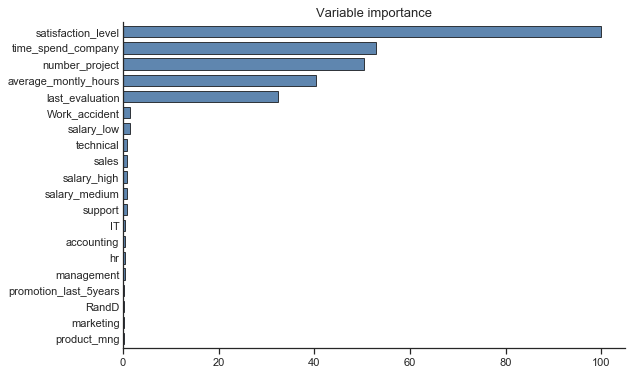

In [34]:
from tutorial9 import plot_feature_importance

plot_feature_importance(rf, feature_names)
plt.show()

You should use the [TreeExplainer](https://shap-lrjball.readthedocs.io/en/docs_update/generated/shap.TreeExplainer.html) class to compute SHAP values for tree-based methods. This algorithms works much faster for trees than generic methods for obtained SHAP values. 

In [58]:
import shap

explainer = shap.TreeExplainer(rf)
shap.initjs()

The random forests tends to predict probabilities that are close to zero or one, therefore let's pick a prediction that is a bit less extreme for local interpretation. 

In [59]:
# 21
x = X_valid.iloc[[21], :]
shap_values = explainer.shap_values(x)

shap.force_plot(explainer.expected_value[1], shap_values[1], feature_names = feature_names)

# explainer.expected_value[1] gives the base values for class index one (left the company)
# Simiarly, shap_values[1] gives the SHAP values for class index one (left the company)

You can perform global interpretation exactly as in the Week 4 tutorial, but computing SHAP values for the whole training or validation set takes a while to run. 

# 8. Probability Calibration

A reliability curve is a a figure allows us to check whether a probabilistic model for classification produces well-calibrated probabilities. If a model is well-calibrated, then among cases for which it estimates probabilities close to (say) 0.5, around 50% of these cases should be actual positives. 

The next cell shows that the random forest is poorly calibrated, which is common for this method.

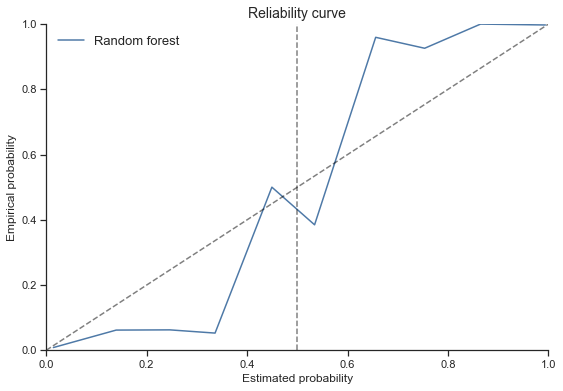

In [97]:
from tutorial9 import plot_calibration_curves
from sklearn.model_selection import cross_val_predict

y_prob = cross_val_predict(rf, X_train, y_train, cv = 5, method='predict_proba')[:,1]
fig, ax = plot_calibration_curves(y_train, y_prob, labels='Random forest')
ax.axvline(0.5, color='black', linestyle='dashed', alpha = 0.5) # decision threshold
plt.show()

It can be useful to apply probability calibration methods to try improve the estimates. We do not cover the details of probability calibration in this unit, but the following code shows you how to do it. 

In [98]:
%%time 
from sklearn.calibration import CalibratedClassifierCV
calibrated_rf = CalibratedClassifierCV(rf, cv = 5, method='isotonic') 
calibrated_rf.fit(X_train, y_train)

CPU times: user 31.7 s, sys: 401 ms, total: 32.1 s
Wall time: 32.3 s


CalibratedClassifierCV(base_estimator=RandomForestClassifier(max_features=7,
                                                             n_estimators=1000,
                                                             random_state=1),
                       cv=5, method='isotonic')

# 9. Model selection

Our benchmark will be the logistic regression model:

In [49]:
logit = LogisticRegressionCV()
logit.fit(X_train, y_train)

LogisticRegressionCV()

The results show that the tree-based methods strongly outperform the logistic regression for this dataset. 
Bagging more than halves the error rate compared to a single decision tree. Perhaps because bagging is already very accurate, the random forest only leads to a small additional gain. 

Note how probability calibration substantially improves the cross-entropy loss. 

In [51]:
columns=['Error Rate', 'Sensitivity', 'Specificity', 'Precision', 'AUC', 'Cross-entropy']
rows=['Logistic', 'Classification Tree', 'Bagged trees', 'Random forest', 'RF calibrated']
results=pd.DataFrame(0.0, columns=columns, index=rows) 

methods=[logit, tree, bag, rf, calibrated_rf]

y_prob = np.zeros((len(y_valid), len(rows)))

for i, method in enumerate(methods):
    y_prob[:, i] = method.predict_proba(X_valid)[:, 1]
    y_pred = method.predict(X_valid)

    tn, fp, fn, tp = confusion_matrix(y_valid, y_pred).ravel() 

    results.iloc[i,0] =   1 - accuracy_score(y_valid, y_pred)
    results.iloc[i,1] =  tp/(tp+fn)
    results.iloc[i,2] =  tn/(tn+fp)
    results.iloc[i,3] =  precision_score(y_valid, y_pred)
    results.iloc[i,4] =  roc_auc_score(y_valid, y_prob[:,i])
    results.iloc[i,5] =  log_loss(y_valid, y_prob[:,i])

In [52]:
results.round(3)

,Error Rate,Sensitivity,Specificity,Precision,AUC,Cross-entropy
Logistic,0.200,0.39,0.928,0.630,0.821,0.428
Classification Tree,0.022,0.92,0.996,0.986,0.982,0.093
Bagged trees,0.010,0.97,0.996,0.988,0.993,0.087
Random forest,0.009,0.97,0.997,0.991,0.994,0.059
RF calibrated,0.009,0.97,0.997,0.991,0.994,0.048


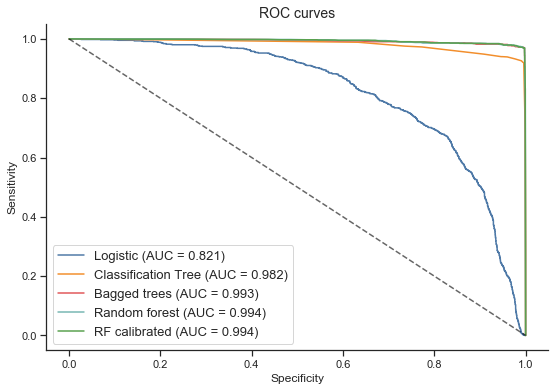

In [53]:
from tutorial9 import plot_roc_curves

fig, ax = plot_roc_curves(y_valid, y_prob, labels=pd.Series(rows))
plt.show()

# Lecture Notes

### Decision Trees

[Visualisation of Decision tree process](https://jakevdp.github.io/PythonDataScienceHandbook/05.08-random-forests.html)

[Example of Non-Linear Data](https://www.jeremyjordan.me/decision-trees/)

[Example of decision tree pruity](https://gdcoder.com/decision-tree-regressor-explained-in-depth/)

### Cost Complexity Pruning

https://www.isip.piconepress.com/courses/msstate/ece_8463/lectures/current/lecture_27/lecture_27_07.html

https://sanchitamangale12.medium.com/decision-tree-pruning-cost-complexity-method-194666a5dd2f

### Number of Jelly Beans in a Jar
Suppose I had a jar of Jelly Beans and I wanted you to guess the number of jelly beans in this jar.

<center><img src="https://cdn.shopify.com/s/files/1/1009/8338/products/2015-10-12-18.42.jpg?v=1445378595" width="250"></center>

Of course, it is very difficult to get the exact number of jelly beans. But, instead if I take an average of 1000 predictions, turns out this average because very close to the exact number.

[TIL that 160 people were able to guess the number of jelly beans in a jar accurate to .1% when their answers were averaged. Out of 4510 beans, the average guess was 4514. The phenomena is known as wisdom of the crowd](https://old.reddit.com/r/todayilearned/comments/1ogik8/til_that_160_people_were_able_to_guess_the_number/#:~:text=InSign%20Up-,TIL%20that%20160%20people%20were%20able%20to%20guess%20the%20number,as%20wisdom%20of%20the%20crowd).

This idea is known as the wisdom of the crowd-

    The wisdom of the crowd is the collective opinion of a group of individuals rather than that of a single expert ... An explanation for this phenomenon is that there is idiosyncratic noise associated with each individual judgment, and taking the average over a large number of responses will go some way toward canceling the effect of this noise.
    - Wikipedia



### Ensemble Models
Ensembling is a very easy idea. Instead of building 1 model, why don't we build $M$ models and take the average of them. In particular, if $G_1(x), G_2(x),\cdots G_M(x)$ are our $M$ models (importantly these models can all be different, one can be linear regression, KNN, trees, etc.). Then the ensemble prediction is simply the average of these models.

$$\mathcal{G}_M(x)=\frac{1}{M}\sum_{i=1}^MG_i(x)$$

### Why Ensemble
Take $X_i$ to be random variable, and independent and identically distributed. Than what we know is that if
$$\textrm{Var}(X_i)=\sigma^2$$

Then the variance of the average $\bar{X}$
$$\textrm{Var}(\bar{X})=\textrm{Var}\left(\frac{1}{n}\sum_{i=1}^{n} X_i\right)=\frac{\sigma^2}{n}$$

In otherwords, the variance of the average decreases as we increase $n$, the sample size.

How this relates to use is that we can think of the prediction of a given model (could be any model, doesn't need to be trees) to be a random variable. Then when we ensemble models together, we are effectively taking the average of all these random variables. As such, this will decrease the variance of our models.

However, our models aren't independent, typically. So, if $X_i$ are identically distributed (dropping independent assumption), then
$$\textrm{Var}(\bar{X})=\rho\sigma^2+\frac{1-\rho}{n}\sigma^2$$
where $\rho$ is the correlation of $X_i$'s.

So really when we are ensembling we want to do two things. 
1. Increase $M$, the number of models, 
2. Make the correlations $\rho$ as small as we can.

### Ways to Ensemble
1. Different algorithms
2. Different training sets
3. Bagging or Bootstrapping (Random Forests)
4. Boosting (xgboost)

### Bootstrapping
Bootstrapping is a general techinique that can be used to estimate any statistical measure. 

The main idea is to create several subsets of data from training sample chosen randomly with replacement. Now, each collection of subset data is used to train their decision trees. As a result, we end up with an ensemble of different models.

https://towardsdatascience.com/decision-tree-ensembles-bagging-and-boosting-266a8ba60fd9

In [49]:
import random

X = [1, 2, 3, 4, 5, 6]

In [2]:
bootstrap = {}

bootstrap[1] = [random.choice(X) for i in range(5)]
bootstrap[2] = [random.choice(X) for i in range(5)]
bootstrap[3] = [random.choice(X) for i in range(5)]

In [3]:
for i in range(1, 3 + 1):
    print(f'Bootstrap {i}: {bootstrap[i]} -> Train -> Model {i}')

Bootstrap 1: [3, 5, 4, 5, 2] -> Train -> Model 1
Bootstrap 2: [5, 1, 6, 6, 2] -> Train -> Model 2
Bootstrap 3: [3, 3, 5, 6, 2] -> Train -> Model 3


Since you are training the model on different bootstraps of the data, it will decorrelate the models. Recall

$$\textrm{Var}(\bar{X})=\rho\sigma^2+\frac{1-\rho}{M}\sigma^2$$

Hence by driving down $\rho$, the correlation, it leads to  less variance. But, bias slightly increases

Of course, the more bootstrap samples you make the more models you will train. Hence $M$ increases and resulting in less variance, bias slightly increases

**Jelly Beans**

Going back to the jar of jelly beans, under this new knowledge, it is pretty simply why this works. We are taking a bunch of humans, we train then, and take an ensumble of them. Lucky for us, humans are already decorrelated with themselves. 

But this ensumble will then reduce the variance and bias of humans, hence giving an accurate prediction.

### Why Ensemble Trees
Thinking about the bias variance decomposition of Trees, trees have low bias but high variance. Making an ideal fit for bagging

### Random Forest
Note that bagging (or bootstrapping) only bootstraps the data that each individual trees are trained on. 

But, if we want to decorrelated further we can use a random forest. Where only a fraction of the features is considered at each split (drives down $\rho$) decorellates models.